# First steps with Spark

Rémi Pépin, Arthur Katossky, Ludovic Deneuville

## Before you start

-   [ ] Download this
    <a href="lab1.ipynb" target="_blank">Jupyter Notebook</a>
-   [ ] Follow these
    <a href="../lab-setup.qmd" target="_blank">instructions</a>

## 1 What is Spark ?

### 1.1 Let’s keep it simple.

The intuitive way: Spark distributes tasks to different Worker nodes
(machine executing the tasks).  
The Kubernetes way: Spark distributes tasks to different containers. The
location of containers among the different worker nodes is then handled
by Kubernetes. The more computation power you need, the more containers
get created. It’s a smooth way to save Worker nodes resources. With
Kubernetes, we just speak in terms of Pods rathen than containers.

Pretty handy right ? If you want to have a deeper look on how it’s done,
you can by clicking on the link bellow but you still have some work to
do so don’t waste your time ! You can keep it to the end.

### 1.2 If you want more !

#### Spark Context

The **Spark Context** is an object that hides the complexity of the
underlying infrastructure to perform computation from the Data
Scientist.

This Spark context is a JVM process that gives access to a Spark
**driver** which schedules the tasks and spans tasks across Worker nodes
through Executors. In brief, the Spark driver communicates with all the
Worker nodes.

Each Worker node consists of one or more Executor(s) who are responsible
for running the Task. Executors register themselves with Driver. The
Driver has all the information about the Executors at all the time.

This working combination of Driver and Workers is known as **Spark
Application**.

JVM: Java virtual machine that load, verifies and executes Java
bytecode.

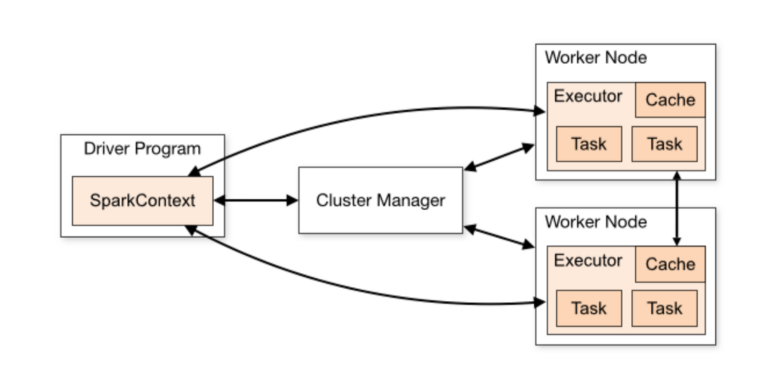

The Spark Application is launched with the help of the **Cluster
Manager**. Spark is dependent on the **Cluster Manager** to launch the
Executors and also the Driver (in Cluster mode).

Spark can be run with any of the 5 following **Cluster Manager** :

-   local : Driver use CPU threads on your local machine
-   Spark Standalone Mode : A basic resource manager provided by Spark
-   YARN : the historical resource manager commonly used in traditional
    Big Data infrastructures (Courdera or Hortonworks cluster for
    instance)
-   Mesos : the resource manager from Berkeley University
-   Kubernetes : the game changing containers orchestrator

#### Spark on a Kubernetes cluster

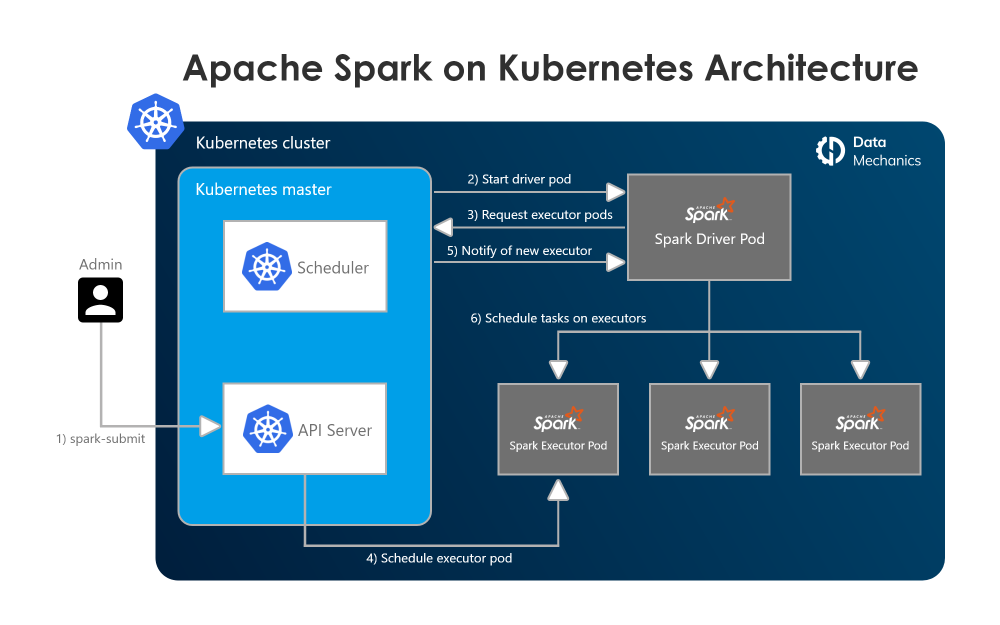

The Spark driver runs on a Kubernetes Pod and creates executors running
within Kubernetes pods. In simple terms, Spark driver is in a Pod and it
distributes tasks to different Pods. The location of Pods among the
different worker nodes is then handled by Kubernetes.

The Kubernetes **Scheduler** checks if pods are assigned to nodes. For
every Pod that the scheduler discovers, the scheduler is responsible of
finding the best node for that Pod to run on.  
The Kubernetes **API Server** allows to interact with Pods. It schedules
executor Pods by creating or deleting Pods.

## 2 Create a Spark session

-   [ ] Depending on the **chosen platform**, initialize the Spark
    session

### 2.1 Only on SSPCloud

See default configuration on the datalab :

In [1]:
! cat /opt/spark/conf/spark-defaults.conf

cat: /opt/spark/conf/spark-defaults.conf: No such file or directory


To modify the config :

In [2]:
import os
from pyspark.sql import SparkSession

spark = (SparkSession
         .builder
         # default url of the internally accessed Kubernetes API
         # (This Jupyter notebook service is itself a Kubernetes Pod)
         .master("k8s://https://kubernetes.default.svc:443")
         # Executors spark docker image: for simplicity reasons, this jupyter notebook is reused
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Name of the Kubernetes namespace
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Allocated memory to the JVM
         # Stay careful, by default, the Kubernetes pods has a higher limit which depends on other parameters.
         .config("spark.executor.memory", "4g")
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         # dynamic allocation configuration
         .config("spark.dynamicAllocation.enabled","true")
         .config("spark.dynamicAllocation.initialExecutors","1")
         .config("spark.dynamicAllocation.minExecutors","1")
         .config("spark.dynamicAllocation.maxExecutors","5")
         .getOrCreate()
        )

In [3]:
# See the current number of executors (one for now)
!kubectl get pods -l spark-role=executor

### 2.2 Only on AWS

In [1]:
#Spark session
spark

# Configuraion
spark._jsc.hadoopConfiguration().set("fs.s3.useRequesterPaysHeader","true")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1715077914757_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.3 Check spark session

In [2]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 First steps with Spark - Data importation

Spark’s main object class is the DataFrame, which is a distributed
table. It is analogous to R’s or Python (Pandas)’s data frames:

-   one row represents an observation,
-   one column represents a variable.

But contrary to R or Python, Spark’s DataFrames can be distributed over
hundred of nodes.

Spark support multiple data formats, and multiple ways to load them.

-   data format : csv, json, parquet (an open source column oriented
    format)
-   can read archive files
-   schema detection or user defined schema. For static data, like a
    json file, schema detection can be use with good results.

Spark has multiple syntaxes to import data. Some are simple with no
customisation, others are more complexes but you can specify options.

The simplest syntaxes to load a json or a csv file are :

``` python
# JSON
json_df = spark.read.json([location of the file])
# csv
csv_df = spark.read.csv([location of the file])
```

In the future, you may consult the [Data Source
documentation](https://spark.apache.org/docs/latest/sql-data-sources.html)
to have the complete description of Spark’s reading abilities.

The data you will use in this lab are real data from the twitter
[sampled stream
API](https://developer.twitter.com/en/docs/twitter-api/tweets/sampled-stream/introduction)
and [filtered stream
API](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/introduction).
The tweets folder contains more than 50 files and more than 2 million
tweets. The tweets was collected between the 14/04/2021 and the
18/04/2021. The total collection time was less than 10 hours.

------------------------------------------------------------------------

### 3.1 ✍Hands-on 1 - Data importation

-   [ ] Load the json file stored here :

    -   `s3a://ludo2ne/diffusion/tweets.jsonl.gz` for SSPCloud
    -   `s3://spark-lab-input-data-ensai20222023/tweets/tweets20220324-155940.jsonl.gz`
        or
        `s3://ensai-labs-2023-2024-files/lab1/tweets20220324-155940.jsonl.gz`
        for AWS

-   [ ] Name you data frame `df_tweet`

-   [ ] Use function `cache()` on the data frame. Caching is a
    performance optimization technique that allows you to persist an
    intermediate or final result of a computation in memory, reducing
    the need to recompute the data when it is accessed multiple time

    <small> ⚙️ This file is an a `JSONL` (JSON-line) format, which means
    that each line of it is a JSON object. A JSON object is just a
    Python dictionary or a JavaScript object and looks like this:
    `{ key1: value1, key2: ["array", "of", "many values]}`. This file
    has been compressed into a `GZ` archive, hence the `.jsonl.gz`
    ending. Also this file is not magically appearing in your S3
    storage. It is hosted on one of your teacher’s bucket and has been
    made public, so that you can access it.</small>

It’s possible to load multiple file in a unique DataFrame. It’s useful
when you have daily files and want to process them all. It’s the same
syntax as the previous one, just specify a folder.

#### if you meet some issue to load this file

You can load and use your own file (available on Moodle):

-   SSPCloud users:
    -   In Onyxia, `mes fichiers`
    -   Load file `tweets.jsonl.gz`
    -   In Jupyter, read it using `s3a://<user_name>/tweets.jsonl.gz`
-   AWS users:
    -   Search for `S3` service
    -   Open or create a bucket
    -   Load file `tweets.jsonl.gz`
    -   in jupyter, read it using :
        `s3://<bucket_name>/<file_name>.jsonl.gz`

In [4]:
# DataFrame creation
df_tweet = spark.read.format("json").load("s3://ensai-labs-2023-2024-files/lab1/tweets20220324-155940.jsonl.gz")

# caching
df_tweet.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[auteur: string, contenu: string, date_creation: string, entities: struct<annotations:array<struct<end:bigint,normalized_text:string,probability:double,start:bigint,type:string>>,cashtags:array<struct<end:bigint,start:bigint,tag:string>>,hashtags:array<struct<end:bigint,start:bigint,tag:string>>,mentions:array<struct<end:bigint,id:string,start:bigint,username:string>>,urls:array<struct<description:string,display_url:string,end:bigint,expanded_url:string,images:array<struct<height:bigint,url:string,width:bigint>>,start:bigint,status:bigint,title:string,unwound_url:string,url:string>>>, hashtags: array<string>, like_count: bigint, other: struct<auteur_name:string>, reply_count: bigint, retweet_count: bigint]

## 4 Data frame basic manipulations

If DataFrames are immutable, they can however be ***transformed*** in
other DataFrames, in the sense that a modified copy is returned. Such
**transformations** include: filtering, sampling, dropping columns,
selecting columns, adding new columns…

First, you can get information about the columns with:

``` python
df.columns       # get the column names
df.schema        # get the column names and their respective type
df.printSchema() # same, but human-readable
```

You can select columns with the `select()` method. It takes as argument
a list of column name. For example :

``` python
df_with_less_columns = df\
  .select("variable3","variable_four","variable-6")

# Yes, you do need the ugly \ at the end of the line,
# if you want to chain methods between lines in Python
```

You can get nested columns easily with :

``` python
df.select("parentField.nestedField")
```

To filter data you could use the `filter()` method. It take as input an
expression that gets evaluated for each observation and should return a
boolean. Sampling is performed with the `sample()` method. For example :

``` python
df_with_less_rows = df\
  .sample(fraction=0.001)\
  .filter(df.variable1=="value")\
  .show(10)
```

As said before your data are distributed over multiple nodes (executors)
and data inside a node are split into partitions. Then each
transformations will be run in parallel. They are called *narrow
transformation* For example, to sample a DataFrame, Spark sample every
partitions in parallel because sample all partition produce the sample
DataFrame. For some transformations, like `groupBy()` it’s impossible,
and it’s cannot be run in parallel.

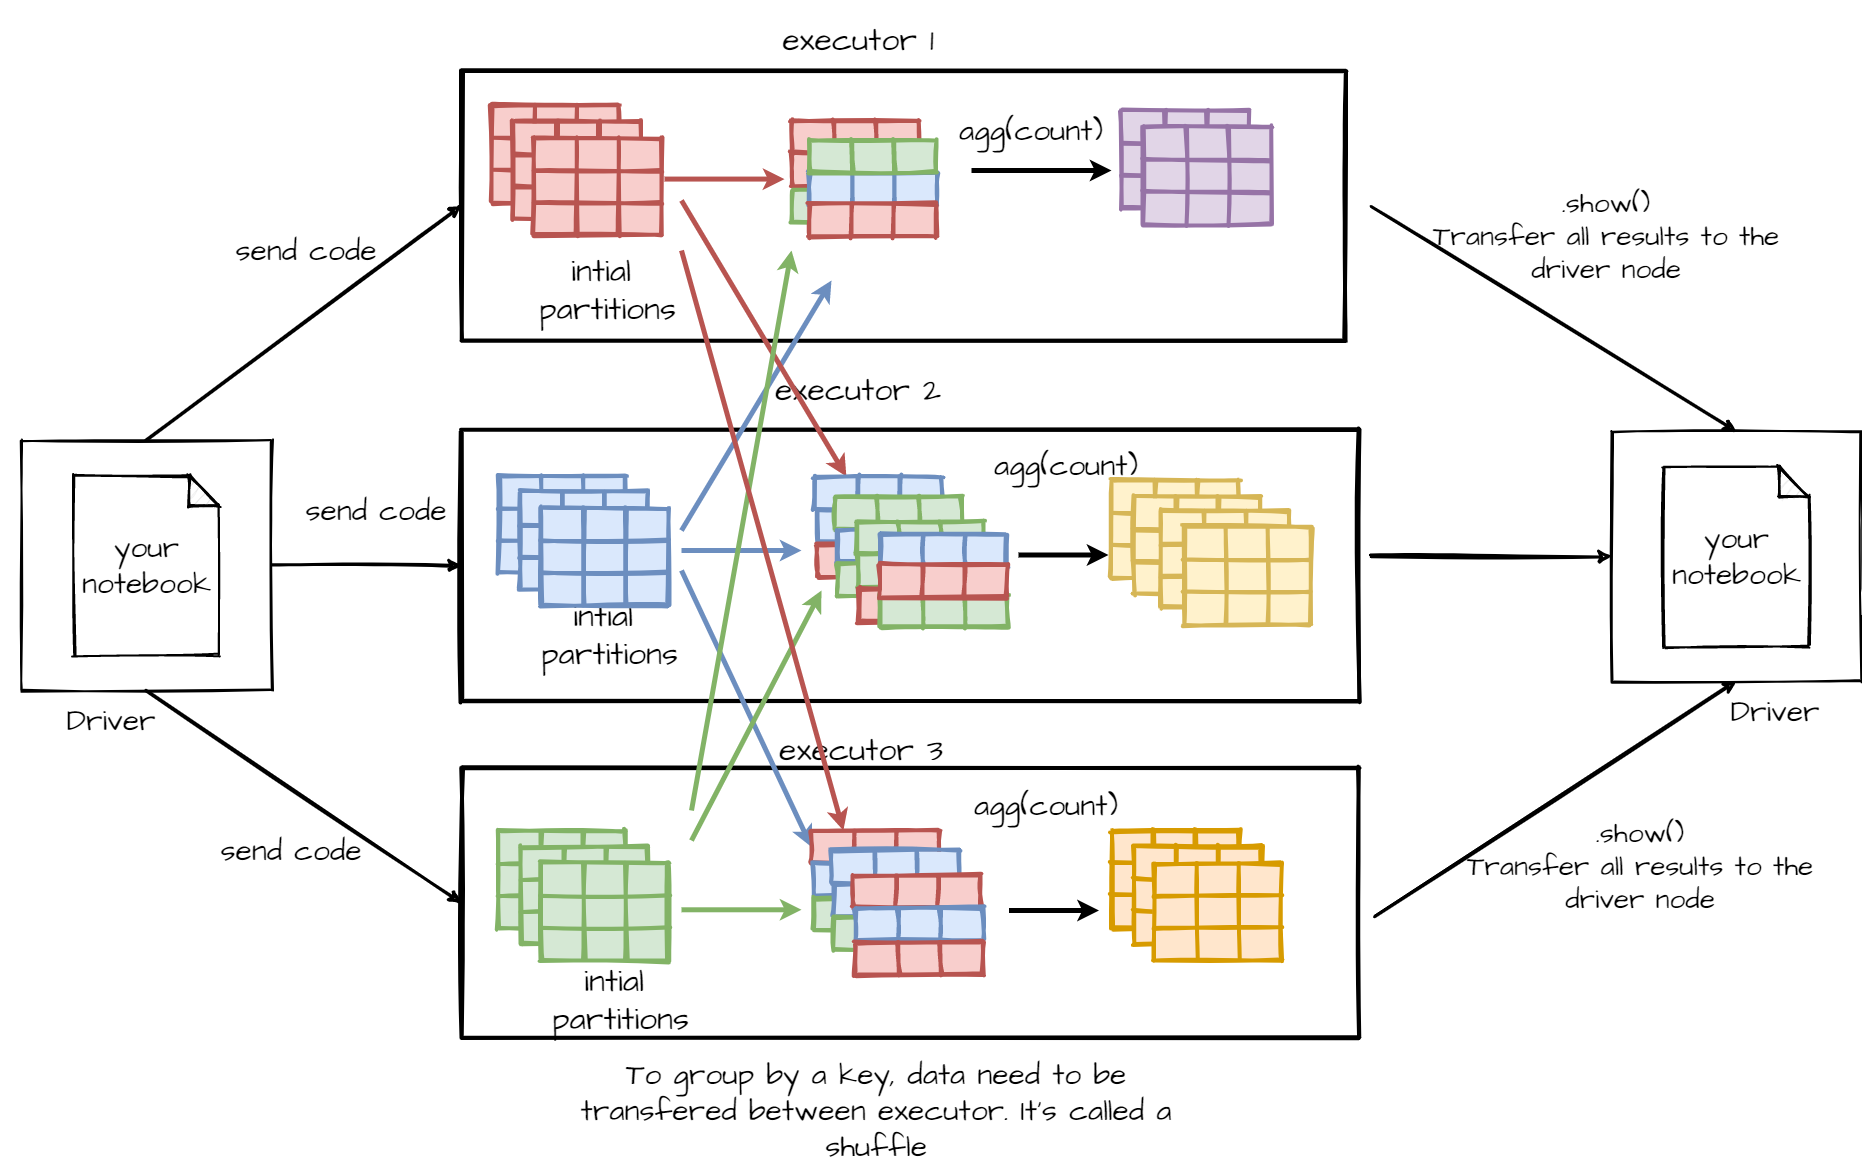

### 4.1 Lazy evaluation

This is because Spark has what is known as **lazy evaluation**, in the
sense that it will wait as much as it can before performing the actual
computation. Said otherwise, when you run an instruction such as:

``` python
tweet_author_hashtags = df_tweet_big.select("auteur","hashtags")
```

… you are not executing anything! Rather, you are building an
**execution plan**, to be realised later.

Spark is quite extreme in its laziness, since only a handful of methods
called **actions**, by opposition to **transformations**, will trigger
an execution. The most notable are:

1.  `collect()`, explicitly asking Spark to fetch the resulting rows
    instead of to lazily wait for more instructions,
2.  `take(n)`, asking for `n` first rows
3.  `first()`, an alias for `take(1)`
4.  `show()` and `show(n)`, human-friendly alternatives
5.  `count()`, asking for the numbers of rows
6.  all the “write” methods (write on file, write to database), see
    [here](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#input-and-output)
    for the list

**This has advantages:** on huge data, you don’t want to accidently
perform a computation that is not needed. Also, Spark can optimize each
**stage** of the execution in regard to what comes next. For instance,
filters will be executed as early as possible, since it diminishes the
number of rows on which to perform later operations. On the contrary,
joins are very computation-intense and will be executed as late as
possible. The resulting **execution plan** consists in a **directed
acyclic graph** (DAG) that contains the tree of all required actions for
a specific computation, ordered in the most effective fashion.

**This has also drawbacks.** Since the computation is optimized for the
end result, the intermediate stages are discarded by default. So if you
need a DataFrame multiple times, you have to cache it in memory because
if you don’t Spark will recompute it every single time.

------------------------------------------------------------------------

### 4.2 ✍Hands-on 2 - Data frame basic manipulations

-   [ ] How many rows have your DataFrame ?

In [5]:
df_tweet.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

100000

-   [ ] Display columns names and then the schema

In [6]:
df_tweet.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['auteur', 'contenu', 'date_creation', 'entities', 'hashtags', 'like_count', 'other', 'reply_count', 'retweet_count']

In [7]:
df_tweet.schema

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

StructType([StructField('auteur', StringType(), True), StructField('contenu', StringType(), True), StructField('date_creation', StringType(), True), StructField('entities', StructType([StructField('annotations', ArrayType(StructType([StructField('end', LongType(), True), StructField('normalized_text', StringType(), True), StructField('probability', DoubleType(), True), StructField('start', LongType(), True), StructField('type', StringType(), True)]), True), True), StructField('cashtags', ArrayType(StructType([StructField('end', LongType(), True), StructField('start', LongType(), True), StructField('tag', StringType(), True)]), True), True), StructField('hashtags', ArrayType(StructType([StructField('end', LongType(), True), StructField('start', LongType(), True), StructField('tag', StringType(), True)]), True), True), StructField('mentions', ArrayType(StructType([StructField('end', LongType(), True), StructField('id', StringType(), True), StructField('start', LongType(), True), StructFi

-   [ ] Display 10 rows of df_tweet

In [8]:
df_tweet.show(n=10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-------------------------------+--------------------+--------------------+--------+----------+--------------------+-----------+-------------+
|         auteur|                        contenu|       date_creation|            entities|hashtags|like_count|               other|reply_count|retweet_count|
+---------------+-------------------------------+--------------------+--------------------+--------+----------+--------------------+-----------+-------------+
|    xwendystian|           RT @karlarboledas...|2022-03-24T14:59:...|{NULL, NULL, NULL...|      []|         0|            {W🚶‍♀️}|          0|          962|
|    suoicilataR|           RT @sooky_co: SLA...|2022-03-24T14:59:...|{NULL, NULL, NULL...|      []|         0|               {Rat}|          0|         3849|
|        SatsuOW|           RT @kusujinn: 👻?...|2022-03-24T14:59:...|{NULL, NULL, NULL...|      []|         0|             {Satsu}|          0|         9787|
|   birashoboka7|           @Kitona_gold You ...

-   [ ] Sample `df_tweet` and keep only 10% of it.
    -   Create a new DataFrame named `df_tweet_sampled`.
    -   If computations take too long on the full DataFrame, use this
        one instead or add a sample transformation in your expression.

In [9]:
df_tweet_sampled = df_tweet.sample(1/10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-   [ ] Define a DataFrame `tweet_author_hashtags` with only the
    `auteur` and `hashtags` columns
    -   [ ] Then display 5 rows

In [10]:
tweet_author_hashtags = df_tweet.select("auteur","hashtags")

tweet_author_hashtags.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------+
|      auteur|hashtags|
+------------+--------+
| xwendystian|      []|
| suoicilataR|      []|
|     SatsuOW|      []|
|birashoboka7|      []|
| TheRealCzia|      []|
+------------+--------+
only showing top 5 rows

-   [ ] Print 5 lines of a **df_tweet** with only the `auteur`,
    `mentions`, and `urls` columns.
    -   `mentions` and `urls` are both nested columns in `entities`

In [11]:
df_tweet.select("auteur","entities.mentions","entities.urls").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+--------------------+
|      auteur|            mentions|                urls|
+------------+--------------------+--------------------+
| xwendystian|[{17, 11851291015...|                NULL|
| suoicilataR|[{12, 14533927358...|[{NULL, pic.twitt...|
|     SatsuOW|[{12, 11935477705...|[{NULL, pic.twitt...|
|birashoboka7|[{12, 14860437391...|                NULL|
| TheRealCzia|                NULL|                NULL|
+------------+--------------------+--------------------+
only showing top 5 rows

-   [ ] Filter **df_tweet** and keep only tweets with more than 1 like.
    -   [ ] Display only `auteur`, `contenu` and `like_count`
    -   [ ] Print 10 lines

In [12]:
df_tweet.filter("like_count>=1").select("auteur","contenu","like_count").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------------------------+----------+
|         auteur|                             contenu|like_count|
+---------------+------------------------------------+----------+
|      DZero_SYS|                @blueberry_lin 🖥...|         1|
|exusial_Penguin|            @Hano_Braves へぇ、い...|         1|
|      queend236|                @dayytonerr I try...|         1|
|      ProBarron|                   ✋#Bitcoin forever|         1|
|enaha1648133622|                Acting is happy a...|         1|
|rwyva1648133803|                Love does not alw...|         1|
|        nhoyvck|                   @jenoleeader meee|         1|
|  Takajyura9_36|ちーぼー、まりこPお疲れさまでした...|         1|
|       Nexion17|                @pizdets17 Even T...|         1|
|MyTomoya_030329|   뮈지? 제광기에 놀라서 두명이나...|         1|
+---------------+------------------------------------+----------+
only showing top 10 rows

## 5 Basic DataFrame column manipulation

You can add/update/rename column of a DataFrame using **spark** :

-   Drop : `df.drop(columnName : str )`
-   Rename : `df.withColumnRenamed(oldName : str, newName : str)`
-   Add/update : `df.withColumn(columnName : str, columnExpression)`

For example

``` python
df_tweet\
  .withColumn(                                        # computes new variable
    "like_rt_ratio",                                  # like_rt_ratio "OVERCONFIDENCE"
    df_tweet.like_count /df_tweet.retweet_count)
```

See <a
href="https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#functions"
class="external" target="_blank">here</a> for the list of all functions
available in an expression.

### 5.1 ✍Hands-on 3 - Basic DataFrame column manipulation

-   [ ] Define a DataFrame with a column names `interaction_count` named
    `df_tweet_interaction_count`
    -   This column is the sum of `like_count`, `reply_count` and
        `retweet_count`.

In [13]:
df_tweet_interaction_count = df_tweet.withColumn("interaction_count", df_tweet.like_count + df_tweet.reply_count + df_tweet.retweet_count)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-   [ ] Update the DataFrame you imported at the beginning of this lab
    and drop the `other` column

In [14]:
df_tweet = df_tweet.drop("other")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 6 Advance DataFrame column manipulation

### 6.1 Array manipulation

Some columns often contain arrays (lists) of values instead of just one
value. This may seem surprising but this actually quite natural. For
instance, you may create an array of words from a text, or generate a
list of random numbers for each observation, etc.

You may **create array of values** with:

-   `split(text : string, delimiter : string)`, turning a text into an
    array of strings

You may **use array of values** with:

-   `size(array : Array)`, getting the number of elements

-   `array_contains(inputArray : Array, value : any)`, checking if some
    value appears

-   `explode(array : Array)`, unnesting an array and duplicating other
    values. For instance if you use `explode()` over the hashtags value
    of this DataFrame:

    | Auteur | Contenu                             | Hashtags           |
    |--------|-------------------------------------|--------------------|
    | Bob    | I love #Spark and #bigdata          | \[Spark, bigdata\] |
    | Alice  | Just finished #MHrise, best MH ever | \[MHrise\]         |

    You will get :

    | Auteur | Contenu                             | Hashtags           | Hashtag |
    |--------|-------------------------------------|--------------------|---------|
    | Bob    | I love #Spark and #bigdata          | \[Spark, bigdata\] | Spark   |
    | Bob    | I love #Spark and #bigdata          | \[Spark, bigdata\] | bigdata |
    | Alice  | Just finished #MHrise, best MH ever | \[MHrise\]         | MHrise  |

All this functions must be imported first :

``` python
from pyspark.sql.functions import split, explode, size, array_contains
```

Do not forget, to create a new column, you should use `withColumn()`.
For example :

``` python
df.withColumn("new column", explode("array"))
```

#### ✍Hands-on 4 - Array manipulation

-   [ ] Keep all the tweets with hashtags and for each remaining line,
    split the hashtag text into an array of hashtags

In [15]:
from pyspark.sql.functions import split, explode, size, array_contains

df_tweet = df_tweet.filter("size(hashtags)>0").withColumn("tags", explode("hashtags"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-   [ ] Create a new column with the number of words of the `contenu`
    column. (Use `split()` + `size()`)

In [16]:
df_tweet = df_tweet.withColumn("number_words", size(split("contenu"," ")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-   [ ] Count how many tweet contain the `Ukraine` hashtag (use the
    `count()` action)

In [18]:
df_tweet.filter("tags=='Ukraine'").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

35

### 6.2 User defined function

For more very specific column manipulation you will need Spark’s `udf()`
function (*User Defined Function*). It can be useful if Spark does not
provide a feature you want. But Spark is a popular and active project,
so before coding an udf, go check the documentation. For instance for
natural language processing, Spark already has some
[functions](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.Tokenizer.html#pyspark.ml.feature.Tokenizer).
Last things, python udf can lead to performance issues (see
https://stackoverflow.com/a/38297050) and learning a little bit of scala
or java can be a good idea.

For example :

``` python
# !!!! DOES NOT WORK !!!!
def to_lower_case(string):
    return string.lower()

df.withColumn("tweet_lower_case", to_lower_case(df.contenu))
```

will just crash. Keep in mind that Spark is a distributed system, and
that Python is only installed on the central node, as a convenience to
let you execute instructions on the executor nodes. But by default, pure
Python functions can only be executed where Python is installed! We need
`udf()` to enable Spark to send Python instructions to the worker nodes.

Let us see how it is done :

``` python
# imports
from pyspark.sql.functions import udf
from pyspark.sql.functions import explode
from pyspark.sql.types import StringType

# pure python functions
def to_lower_case(string):
    return string.lower()

# user defined function(we use a lambda function to create the udf)
to_lower_case_udf = udf(
    lambda x: to_lower_case(x), StringType()
)

# df manipulation
df_tweet_small\
  .select("auteur","hashtags")\
  .filter("size(hashtags)!=0")\
  .withColumn("hashtag", explode("hashtags"))\
  .withColumn("hashtag", to_lower_case_udf("hashtag")).show(10)
```

------------------------------------------------------------------------

#### ✍Hands-on 5 - User defined function

-   [ ] Create an user defined function that counts how many words a
    tweet contains.
    -   your function will return an `IntegerType` and not a
        `StringType`

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import explode
from pyspark.sql.types import IntegerType

def count_words(string):
    nb = len(string.split())+1
    return nb

count_words_udf = udf(lambda x: count_words(x), IntegerType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df_tweet.withColumn("OUU", count_words_udf("contenu")).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----------------------+--------------------+----------------------------+---------------------+----------+-----------+-------------+-----------------+------------+---+
|      auteur|                contenu|       date_creation|                    entities|             hashtags|like_count|reply_count|retweet_count|             tags|number_words|OUU|
+------------+-----------------------+--------------------+----------------------------+---------------------+----------+-----------+-------------+-----------------+------------+---+
|     GIimoto|RT @aabbeecc: 日本コ...|2022-03-24T14:59:...|{[{21, 日本コカ・コーラ, ...|[utamaru, コークオン]|         0|          0|            4|          utamaru|           5|  6|
|     GIimoto|RT @aabbeecc: 日本コ...|2022-03-24T14:59:...|{[{21, 日本コカ・コーラ, ...|[utamaru, コークオン]|         0|          0|            4|       コークオン|           5|  6|
|  MEWWhiskey|   📍เปิดหาร nct dre...|2022-03-24T14:59:...|        {NULL, NULL, [{14...| [ตลาดนัดnctdream,...|         0|  

## 7 Aggregation functions

Spark offer a variety of aggregation functions :

-   `count(column : string)` will count every not null value of the
    specify column. You cant use `count(1)` of `count("*")` to count
    every line (even row with only null values)

-   `countDisctinct(column : string)` and
    `approx_count_distinct(column : string, percent_error: float)`. If
    the exact number is irrelevant, `approx_count_distinct()`should be
    preferred.

    Counting distinct elements cannot be done in parallel, and need a
    lot data transfer. But if you only need an approximation, there is a
    algorithm, named hyper-log-log (more info
    [here](https://databricks.com/fr/blog/2016/05/19/approximate-algorithms-in-apache-spark-hyperloglog-and-quantiles.html))
    that can be parallelized.

    ``` python
    from pyspark.sql.functions import count, countDistinct, approx_count_distinct

    df.select(count("col1")).show()
    df.select(countDistinct("col1")).show()
    df.select(approx_count_distinct("col1"), 0.1).show()
    ```

-   You have access to all other common functions `min()`, `max()`,
    `first()`, `last()`, `sum()`, `sumDistinct()`, `avg()` etc (you
    should import them first
    `from pyspark.sql.functions import min, max, avg, first, last, sum, sumDistinct`)

------------------------------------------------------------------------

### 7.1 ✍Hands-on 6 - Aggregation functions

-   [ ] What are the min, max, average of `interaction_count` (use
    `df_tweet_interaction_count` created earlier)
    -   don’t forget to import the required functions

In [26]:
from pyspark.sql.functions import count, countDistinct, approx_count_distinct, min, max, avg, first, last, sum, sumDistinct

df_tweet_interaction_count.select(min("interaction_count")).show()
df_tweet_interaction_count.select(max("interaction_count")).show()
df_tweet_interaction_count.select(avg("interaction_count")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|min(interaction_count)|
+----------------------+
|                     0|
+----------------------+

+----------------------+
|max(interaction_count)|
+----------------------+
|               2667917|
+----------------------+

+----------------------+
|avg(interaction_count)|
+----------------------+
|            1694.87587|
+----------------------+

 -   [ ] How many tweets have hashtags ?
    -   [ ] Distinct hashtags ?
    -   [ ] Try the approximative count with 0.1 and 0.01 as maximum
        estimation error allowed.

In [32]:
df_tweet_interaction_count.filter("size(hashtags)>0").select(count("hashtags")).show()
df_tweet_interaction_count.filter("size(hashtags)>0").select(countDistinct("hashtags")).show()
df_tweet_interaction_count.filter("size(hashtags)>0").select(approx_count_distinct("hashtags",0.1)).show()
df_tweet_interaction_count.filter("size(hashtags)>0").select(approx_count_distinct("hashtags",0.01)).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+
|count(hashtags)|
+---------------+
|          23433|
+---------------+

+------------------------+
|count(DISTINCT hashtags)|
+------------------------+
|                    9319|
+------------------------+

+-------------------------------+
|approx_count_distinct(hashtags)|
+-------------------------------+
|                           7785|
+-------------------------------+

+-------------------------------+
|approx_count_distinct(hashtags)|
+-------------------------------+
|                           9340|
+-------------------------------+

## 8 Grouping functions

Like SQL you can group row by a criteria with Spark. Just use the
`groupBy(column : string)` method. Then you can compute some aggregation
over those groups.

``` python
df\
  .groupBy("col1")\
  .agg(count("col2").alias("quantity"))\           # alias is use to specify the name of the new column
  .show()
```

The `agg()` method can take multiples argument to compute multiple
aggregation at once.

``` python
df\
  .groupBy("col1")\
  .agg(count("col2").alias("quantity"),
       min("col2").alias("min"),
       avg("col3").alias("avg3"))\
  .show()
```

Aggregation and grouping transformations work differently than the
previous method like `filter()`, `select()`, `withColumn()` etc. Those
transformations cannot be run over each partitions in parallel, and need
to transfer data between partitions and executors. They are called “wide
transformations”

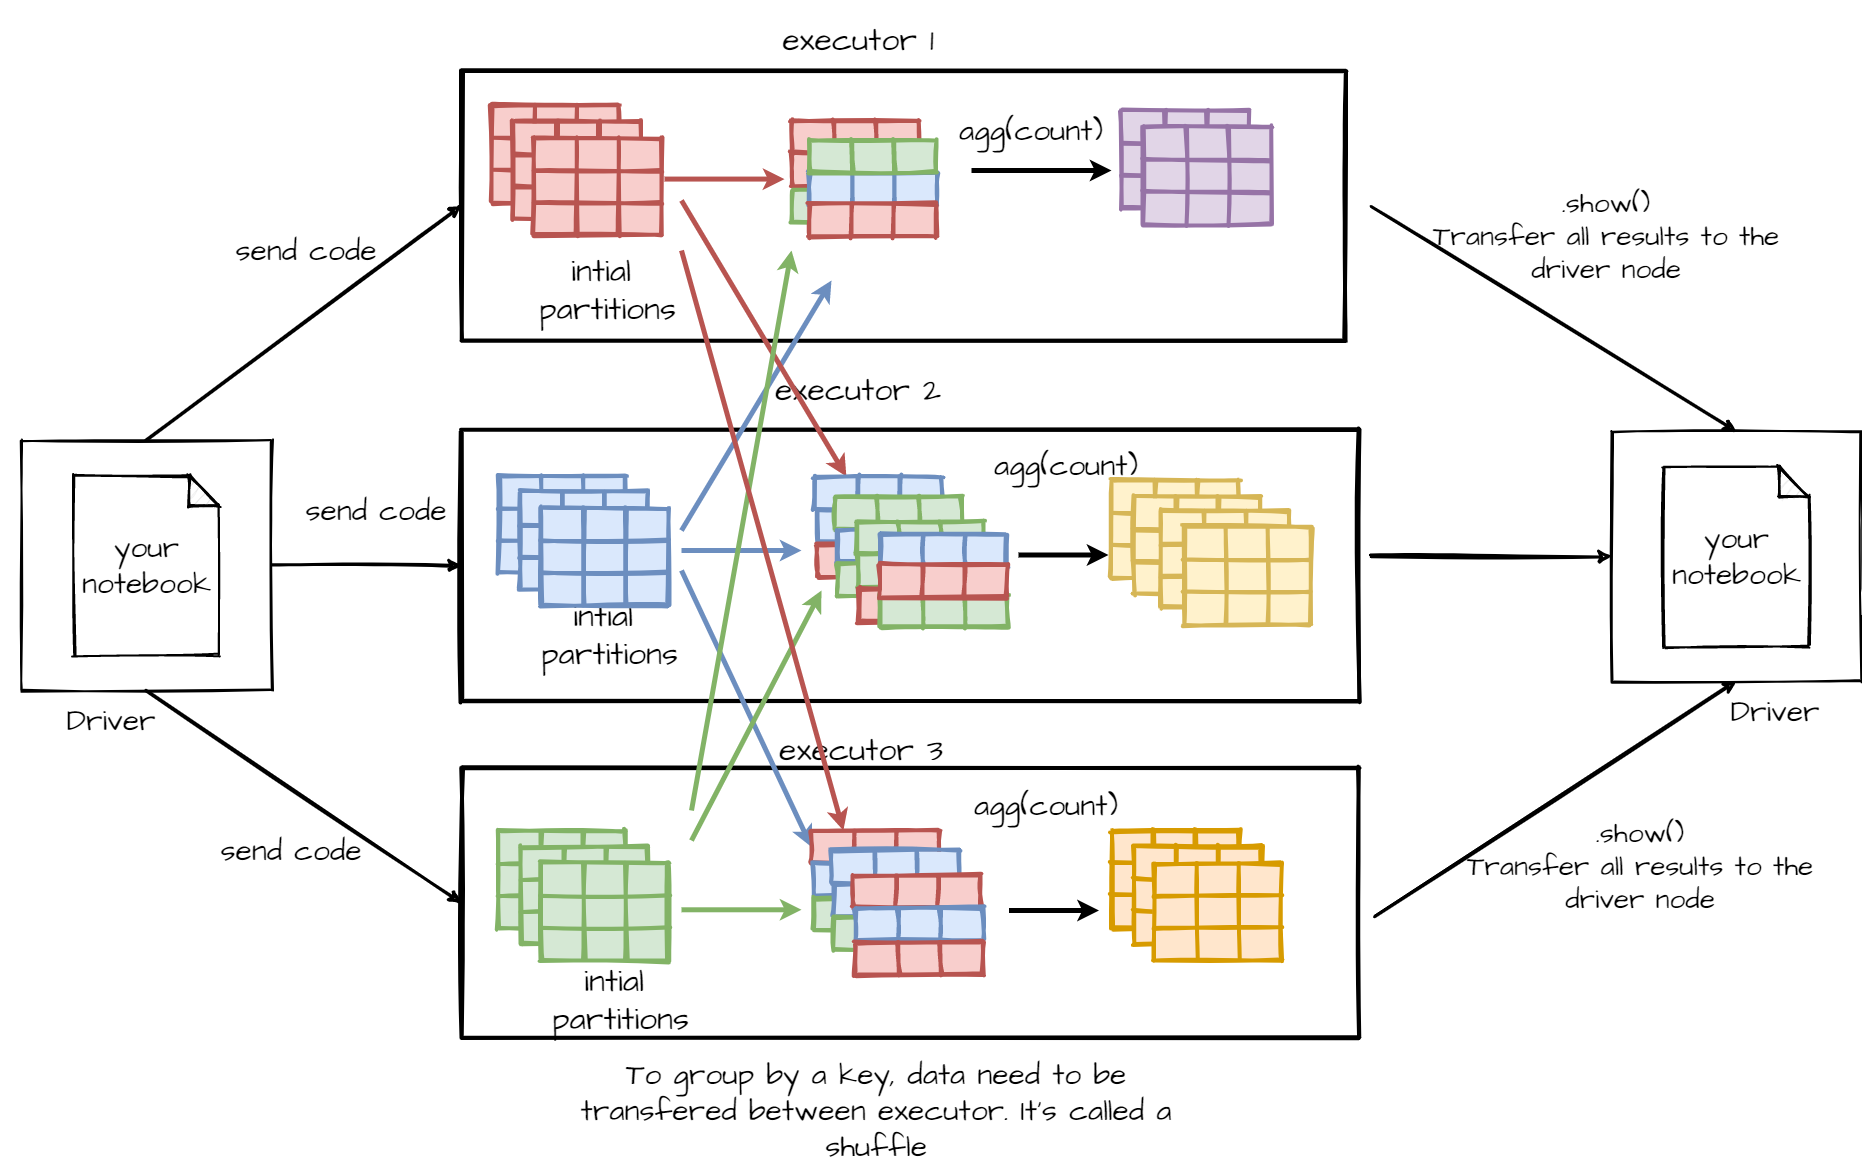

### 8.1 ✍Hands-on 7 - Grouping functions

-   [ ] Compute a daframe with the min, max and average retweet of each
    `auteur`.
    -   [ ] Then order it by the max number of retweet in descending
        order by .
    -   To do that you can use the following syntax

    ``` python
    from pyspark.sql.functions import desc
    df.orderBy(desc("col"))
    ```

In [39]:
from pyspark.sql.functions import desc

df2 = df_tweet.groupBy("auteur").\
    agg(min("retweet_count").alias("min_rt"),
        max("retweet_count").alias("max_rt"),
        avg("retweet_count").alias("avg_rt"))\
    .orderBy(desc("max_rt"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 9 Spark SQL

Spark understand SQL statement. It’s not a hack nor a workaround to use
SQL in Spark, it’s one a the more powerful feature in Spark. To use SQL
you will need :

1.  Register a view pointing to your DataFrame

    ``` python
    my_df.createOrReplaceTempView(viewName : str)
    ```

2.  Use the sql function

    ``` python
    spark.sql("""
    Your SQL statement
    """)
    ```

    You could manipulate every registered DataFrame by their view name
    with plain SQL.

In fact you can do most of this tutorial without any knowledge in
PySpark nor Spark. Many things can only be done in Spark if you know SQL
and how to use it in Spark.

### 9.1 ✍Hands-on 8 - Spark SQL

-   [ ] How many tweets have hashtags ?
    -   [ ] Distinct hashtags ?

In [45]:
df_tweet.createOrReplaceTempView("Vue_df_tweet")

spark.sql("""
SELECT COUNT(hashtags) FROM Vue_df_tweet
""").show()

spark.sql("""
SELECT COUNT(DISTINCT(hashtags)) FROM Vue_df_tweet
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+
|count(hashtags)|
+---------------+
|          50814|
+---------------+

+------------------------+
|count(DISTINCT hashtags)|
+------------------------+
|                    9319|
+------------------------+

-   [ ] Compute a dataframe with the min, max and average retweet of
    each `auteur` using Spark SQL

In [50]:
spark.sql("""
SELECT auteur, MIN(retweet_count) as min_rt, MAX(retweet_count) as max_rt, AVG(retweet_count) as avg_rt
FROM Vue_df_tweet GROUP BY auteur ORDER BY max_rt DESC
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+------+--------+
|         auteur|min_rt|max_rt|  avg_rt|
+---------------+------+------+--------+
|        jeonvro|370759|370759|370759.0|
|         imlla2|325775|325775|325775.0|
|     TinPwumbee|276539|276539|276539.0|
|        KSUkloy|162731|162731|162731.0|
|       mikronu7|159240|159240|159240.0|
|      anchyto16|158009|158009|158009.0|
|     aeeeeaeeae|155969|155969|155969.0|
|Heulwen37321000|153152|153152|153152.0|
| VIJAYDEVAMemes|134688|134688|134688.0|
|AnaSofi86551217|129010|129010|129010.0|
|seokjinnie_tete|129007|129007|129007.0|
|         is4nct|117943|117943|117943.0|
|  infirespotion|110780|110780|110780.0|
|  BTSlegends131|110768|110768|110768.0|
|   Alexa_7stars|110747|110747|110747.0|
|     shirasu156|  2634|109831| 56232.5|
|    miya_homiya|109799|109799|109799.0|
|    cogiulo_893|109790|109790|109790.0|
|bBBlxOB78CCwOhE|106521|106521|106521.0|
|     iceboyyy02|104430|104430|104430.0|
+---------------+------+------+--------+
only showing top

## End of the Lab

-   [ ] Export your notebook
    -   Right click and Download (.ipynb)
    -   File \> Save and Export Notebook \> HTML

### SSPCloud

-   [ ] Delete the Jupyter-pyspark service
    -   <a href="https://datalab.sspcloud.fr/my-services"
        target="_blank">SSPCloud &gt; My services &gt; Delete</a>

### AWS

-   [ ] Terminate your cluster
    -   On *EMR* service page, click on *Clusters*
    -   Select the active cluster and click on `Terminate`

> **Solution**
>
> <a href="lab1-correction.qmd" target="_blank">Solution</a>